In [1]:
#install Kaggle
!pip install -q kaggle

from google.colab import files
files.upload()
#create a kaggle folder
!mkdir ~/.kaggle

#copy the kaggle.json to folder created
!cp kaggle.json ~/.kaggle/

#permission for the json to act
! chmod 600 ~/.kaggle/kaggle.json
#!/bin/bash
! kaggle datasets download jessicali9530/celeba-dataset
! unzip /content/celeba-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: img_align_celeba/img_align_celeba/197604.jpg  
  inflating: img_align_celeba/img_align_celeba/197605.jpg  
  inflating: img_align_celeba/img_align_celeba/197606.jpg  
  inflating: img_align_celeba/img_align_celeba/197607.jpg  
  inflating: img_align_celeba/img_align_celeba/197608.jpg  
  inflating: img_align_celeba/img_align_celeba/197609.jpg  
  inflating: img_align_celeba/img_align_celeba/197610.jpg  
  inflating: img_align_celeba/img_align_celeba/197611.jpg  
  inflating: img_align_celeba/img_align_celeba/197612.jpg  
  inflating: img_align_celeba/img_align_celeba/197613.jpg  
  inflating: img_align_celeba/img_align_celeba/197614.jpg  
  inflating: img_align_celeba/img_align_celeba/197615.jpg  
  inflating: img_align_celeba/img_align_celeba/197616.jpg  
  inflating: img_align_celeba/img_align_celeba/197617.jpg  
  inflating: img_align_celeba/img_align_celeba/197618.jpg  
  inflating: img_align_celeba/img_align_celeba/19

In [3]:
!pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 55.4 MB/s eta 0:00:00


In [4]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as PL
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.transforms import *
from torchvision.utils import make_grid
import os
from PIL import Image

In [5]:
class CelebADataset(Dataset):
    def __init__(self, dataset_dir, max_samples=200000):
        self.dataset_dir = dataset_dir
        self.image_files = os.listdir(self.dataset_dir)[:max_samples]
        self.transform_pipeline = transforms.Compose([
            ToTensor(),
            Resize((64, 64)),
            Normalize(mean=0, std=1)
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_filename = self.image_files[idx]
        image_path = os.path.join(self.dataset_dir, image_filename)
        image = Image.open(image_path)
        return self.transform_pipeline(image)


In [6]:
# Instantiate the CelebADataset with the specified path to the image folder
celeba_dataset = CelebADataset('/content/img_align_celeba/img_align_celeba')

# Create a DataLoader for batching and shuffling, with a batch size of 32
data_loader = DataLoader(celeba_dataset, batch_size=32, shuffle=True)

# Retrieve the first batch of images from the DataLoader
first_batch_images = next(iter(data_loader))

# Display the shape of the batch to verify dimensions
first_batch_images.shape


torch.Size([32, 3, 64, 64])

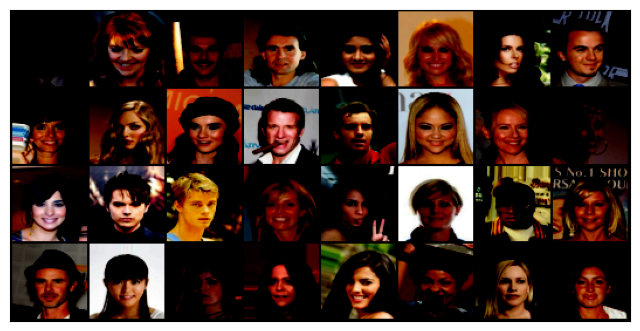

In [21]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch

def show_images(batch, N=32):
    # Set up a square figure to display the images
    plt.figure(figsize=(8, 8))

    # Create a grid of images from the first N images in the batch
    grid = make_grid(batch[:N])

    # Convert the grid to a numpy array and transpose for correct color display
    grid = grid.permute(1, 2, 0).cpu().numpy()

    # Display the image grid
    plt.imshow(grid)
    plt.xticks([])  # Remove x-axis ticks
    plt.yticks([])  # Remove y-axis ticks
    plt.show()

# Fetch any other batch from the data loader
# Here, we fetch the second batch as an example
second_batch_images = next(iter(train_loader))  # Skip the first iteration by calling `iter` again
second_batch_images = next(iter(train_loader))  # Fetch the next batch

# Display the images in the second batch
show_images(second_batch_images[0])  # Assuming `second_batch_images` is a tuple (images, labels)


In [8]:
import torch
import torch.nn as nn

# Define the generator model class
class GANGenerator(nn.Module):
    def __init__(self, noise_dim=128):
        super(GANGenerator, self).__init__()
        # Store the dimension of the latent space (input noise vector)
        self.noise_dim = noise_dim

        # Define the sequential model for the generator
        self.generator_network = nn.Sequential(
            # Fully connected layer to expand the noise vector
            nn.Linear(self.noise_dim, 512 * 4 * 4),
            nn.BatchNorm1d(512 * 4 * 4),
            nn.ReLU(inplace=True),

            # Reshape the output to match the dimensions for ConvTranspose2d
            nn.Unflatten(1, (512, 4, 4)),

            # First transposed convolutional layer to upsample the feature map
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            # Second transposed convolutional layer
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            # Third transposed convolutional layer
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            # Final transposed convolutional layer to get the desired output channel (3 for RGB)
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Use Sigmoid to bring output values in the range [0, 1]
        )

    # Define the forward pass of the generator
    def forward(self, input_noise):
        # Pass the input noise through the generator network
        return self.generator_network(input_noise)


In [9]:
import torch
import torch.nn as nn

# Define the discriminator model class
class GANDiscriminator(nn.Module):
    def __init__(self):
        super(GANDiscriminator, self).__init__()

        # Define the sequential model for the discriminator
        self.discriminator_network = nn.Sequential(
            # First convolutional layer to process the 3-channel input (e.g., RGB image)
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            # Second convolutional layer with batch normalization
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            # Third convolutional layer with batch normalization
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            # Fourth convolutional layer with batch normalization
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            # Flatten the output to prepare for the fully connected layer
            nn.Flatten(),
            # Fully connected layer to produce a single output
            nn.Linear(512 * 4 * 4, 1),
            # Sigmoid activation to output a value between 0 and 1 (real/fake prediction)
            nn.Sigmoid()
        )

    # Define the forward pass of the discriminator
    def forward(self, image_input):
        # Pass the image through the discriminator network
        return self.discriminator_network(image_input)


In [10]:
import pytorch_lightning as pl
import torch
import torch.nn as nn

# Define the GAN training class using PyTorch Lightning
class GANModel(pl.LightningModule):
    def __init__(self, discriminator, generator, latent_dim=128):
        super(GANModel, self).__init__()

        # Disable automatic optimization for manual control over optimizers
        self.automatic_optimization = False
        # Initialize the discriminator and generator models
        self.discriminator = discriminator
        self.generator = generator
        # Define the dimensionality of the latent space (input noise for generator)
        self.latent_dim = latent_dim
        # Use binary cross-entropy as the loss function for GAN
        self.adversarial_loss = nn.BCELoss()

    # Forward method to generate images from noise
    def forward(self, noise):
        return self.generator(noise)

    # Configure optimizers for both generator and discriminator
    def configure_optimizers(self):
        gen_optimizer = torch.optim.Adam(self.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        disc_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        return [gen_optimizer, disc_optimizer], []

    # Method to generate images for visualization
    def generate_images(self, num_images=32):
        # Sample random noise and generate images
        noise = torch.randn(num_images, self.latent_dim).type_as(self.generator.model[0].weight)
        return self.generator(noise)

    # Define the training step for each batch
    def training_step(self, batch, batch_idx):
        # Get the batch of real images
        real_images = batch
        batch_size = real_images.size(0)
        # Retrieve optimizers for generator and discriminator
        gen_optimizer, disc_optimizer = self.optimizers()

        # Train Discriminator
        for _ in range(2):
            # Generate fake images from random noise
            noise = torch.randn(batch_size, self.latent_dim).type_as(real_images)
            fake_images = self.generator(noise)
            # Get discriminator scores for fake and real images
            fake_preds = self.discriminator(fake_images)
            real_preds = self.discriminator(real_images)

            # Calculate the loss for fake and real images
            fake_loss = self.adversarial_loss(fake_preds, torch.zeros_like(fake_preds).type_as(fake_preds))
            real_loss = self.adversarial_loss(real_preds, torch.ones_like(real_preds).type_as(real_preds))
            disc_loss = (fake_loss + real_loss) / 2.0

            # Backpropagation and optimization step for discriminator
            disc_optimizer.zero_grad()
            self.manual_backward(disc_loss)
            disc_optimizer.step()

        # Train Generator
        noise = torch.randn(batch_size, self.latent_dim).type_as(real_images)
        fake_images = self.generator(noise)
        fake_preds = self.discriminator(fake_images)
        gen_loss = self.adversarial_loss(fake_preds, torch.ones_like(fake_preds))

        # Backpropagation and optimization step for generator
        gen_optimizer.zero_grad()
        self.manual_backward(gen_loss)
        gen_optimizer.step()

        # Log the losses for generator and discriminator
        self.log_dict({'generator_loss': gen_loss, 'discriminator_loss': disc_loss}, prog_bar=True, on_epoch=True)

    # Custom training loop to integrate with the PyTorch Lightning trainer
    def train_model(self, data_loader, num_epochs=1, device='gpu'):
        trainer = pl.Trainer(accelerator=device, max_epochs=num_epochs)
        trainer.fit(self, data_loader)


In [11]:
# Instantiate the discriminator and generator models
discriminator_model = GANDiscriminator()
generator_model = GANGenerator()

# Create an instance of the GAN model with the discriminator and generator
gan_model = GANModel(discriminator_model, generator_model)

# Display the GAN model structure
gan_model


GANModel(
  (discriminator): GANDiscriminator(
    (discriminator_network): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.2, inplace=True)
      (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): LeakyReLU(negative_slope=0.2, inplace=True)
      (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): LeakyReLU(negative_slope=0.2, inplace=True)
      (11): Flatten(start_dim=1, end_dim=-1)
      (12): Linear(in_features=8192, out_features=1, bias=

In [16]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Resize, Normalize
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Step 1: Define the Dataset and DataLoader
# Replace '/path/to/your/dataset' with the actual path to your dataset
dataset_path = '/content/img_align_celeba'  # Update this path as needed

# Define the transformations to be applied to each image
transform = transforms.Compose([
    Resize((64, 64)),
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalization for RGB channels
])

# Load the dataset and create a DataLoader
celeba_dataset = ImageFolder(root=dataset_path, transform=transform)
train_loader = DataLoader(celeba_dataset, batch_size=32, shuffle=True)

# Step 2: Define the Discriminator and Generator classes (same as previously defined)
class GANDiscriminator(nn.Module):
    def __init__(self):
        super(GANDiscriminator, self).__init__()
        self.discriminator_network = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(512 * 4 * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, image_input):
        return self.discriminator_network(image_input)

class GANGenerator(nn.Module):
    def __init__(self, noise_dim=128):
        super(GANGenerator, self).__init__()
        self.generator_network = nn.Sequential(
            nn.Linear(noise_dim, 512 * 4 * 4),
            nn.BatchNorm1d(512 * 4 * 4),
            nn.ReLU(inplace=True),
            nn.Unflatten(1, (512, 4, 4)),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()  # Using Tanh for outputs in range [-1, 1]
        )

    def forward(self, input_noise):
        return self.generator_network(input_noise)

# Step 3: Define the GAN Model with PyTorch Lightning
class GANModel(pl.LightningModule):
    def __init__(self, discriminator, generator, latent_dim=128):
        super(GANModel, self).__init__()
        self.automatic_optimization = False
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.adversarial_loss = nn.BCELoss()

    def forward(self, noise):
        return self.generator(noise)

    def configure_optimizers(self):
        gen_optimizer = torch.optim.Adam(self.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        disc_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        return [gen_optimizer, disc_optimizer], []

    def training_step(self, batch, batch_idx):
        real_images, _ = batch
        batch_size = real_images.size(0)
        gen_optimizer, disc_optimizer = self.optimizers()

        # Train Discriminator
        for _ in range(2):
            noise = torch.randn(batch_size, self.latent_dim, device=self.device)
            fake_images = self.generator(noise)
            fake_preds = self.discriminator(fake_images.detach())
            real_preds = self.discriminator(real_images)
            fake_loss = self.adversarial_loss(fake_preds, torch.zeros_like(fake_preds))
            real_loss = self.adversarial_loss(real_preds, torch.ones_like(real_preds))
            disc_loss = (fake_loss + real_loss) / 2

            disc_optimizer.zero_grad()
            self.manual_backward(disc_loss)
            disc_optimizer.step()

        # Train Generator
        noise = torch.randn(batch_size, self.latent_dim, device=self.device)
        fake_images = self.generator(noise)
        fake_preds = self.discriminator(fake_images)
        gen_loss = self.adversarial_loss(fake_preds, torch.ones_like(fake_preds))

        gen_optimizer.zero_grad()
        self.manual_backward(gen_loss)
        gen_optimizer.step()

        self.log_dict({'gen_loss': gen_loss, 'disc_loss': disc_loss}, prog_bar=True, on_epoch=True)

    def generate_images(self, num_images=32):
        noise = torch.randn(num_images, self.latent_dim, device=self.device)
        return self.generator(noise)

# Step 4: Initialize the models and train
discriminator_model = GANDiscriminator()
generator_model = GANGenerator()
gan_model = GANModel(discriminator_model, generator_model)

# Set device as GPU if available, otherwise use CPU
device = 'gpu' if torch.cuda.is_available() else 'cpu'

# Instantiate the PyTorch Lightning Trainer and train the model
trainer = pl.Trainer(accelerator=device, max_epochs=2)
trainer.fit(gan_model, train_loader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type             | Params | Mode 
--------------------------------------------------------------
0 | discriminator    | GANDiscriminator | 1.6 M  | train
1 | generator        | GANGenerator     | 2.6 M  | train
2 | adversarial_loss | BCELoss          | 0      | train
--------------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.742    Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


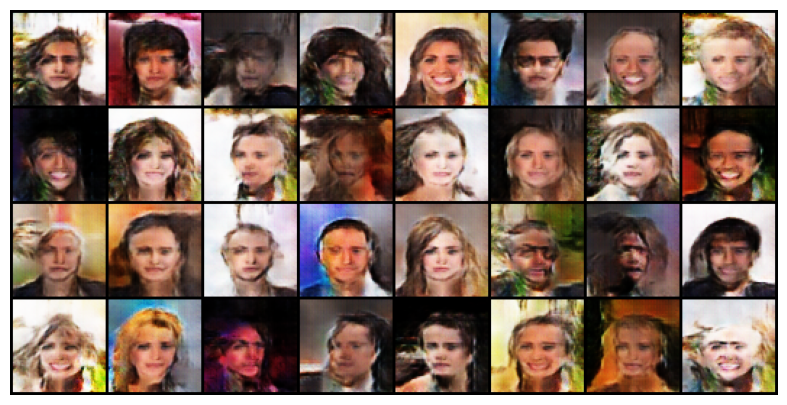

In [20]:
# Generate a batch of images using the GAN model
generated_images = gan_model.generate_images(num_images=32)

# Function to display generated images in a 4x8 grid format
def show_images_in_grid(images, num_images=32, nrow=8):
    # Set up the figure size
    plt.figure(figsize=(10, 5))  # Adjust figure size for 4x8 layout

    # Normalize the images to [0, 1] if they are in the range [-1, 1]
    images = (images + 1) / 2  # Assuming the generator uses Tanh

    # Create a grid of images with nrow=8 (4 rows, 8 columns)
    grid = make_grid(images[:num_images], nrow=nrow, normalize=False)

    # Convert to numpy format and transpose to (H, W, C)
    grid = grid.permute(1, 2, 0).cpu().numpy()

    # Display the image grid
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

# Display the generated images in the new grid layout
show_images_in_grid(generated_images, nrow=8)
